In [27]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from collections import Counter
import transformers
from transformers import pipeline
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import preprocessing
import pickle
import pandas as pd
import os
import re
from collections import defaultdict
import comprehension_model
import numpy as np
from scipy.stats import ttest_ind

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [7]:
exbert_tokenizer=AutoTokenizer.from_pretrained("exbert_tokenizer")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
from transformers import PreTrainedTokenizerFast

swerick_tokenizer= PreTrainedTokenizerFast(
    tokenizer_file="/home/laurinemeier/swerick/alvis_project/pretraining_from_scratch/tokenizer_swerick.json",
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]"
)

In [4]:
model_kb = preprocessing.create_model_MLM(model_checkpoint)
model_kb=model_kb.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)

In [ ]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)

valid_dataset

In [ ]:
valid_dataset=valid_dataset.remove_columns(["word_ids"])
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])

print(lm_dataset_bis["test"])
eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset,data_collator)

In [ ]:
from datasets import Dataset
valid_dataset=valid_dataset.remove_columns(["word_ids"])
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
small_valid_dataset = preprocessing.create_deterministic_eval_dataset(valid_dataset.select(range(10000)),data_collator)
small_valid_dataloader=preprocessing.create_dataloader(small_valid_dataset,64,default_data_collator)

In [ ]:
batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to(device) for key, value in batch.items()}

print("ok")
eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,batch_size,default_data_collator)

In [17]:
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-2175500")
model_hugging_face=model_hugging_face.to(device)

In [5]:
model_exbert = AutoModelForMaskedLM.from_pretrained("exbert-finetuned-imdb/checkpoint-1271340")
model_exbert=model_exbert.to(device)

In [16]:
import transformers
config = transformers.BertConfig.from_pretrained("alvis_project/pretraining_from_scratch/checkpoint-5258900")
mosaicBert = AutoModelForMaskedLM.from_pretrained("alvis_project/pretraining_from_scratch/checkpoint-5258900",config=config,trust_remote_code=True)

/home/laurinemeier/.cache/huggingface/modules/transformers_modules/checkpoint-5258900/bert_layers.py:177: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


In [ ]:
def get_most_frequent_tokens(valid_dataset, top_n=1000):
    token_counts = defaultdict(int)

    for example in valid_dataset: 
        labels = example['labels']
        for label in labels:
            if label != -100:
                token_counts[label] += 1
    
    
    return token_counts

# Example usage
# # Assuming valid_dataset and tokenizer are already loaded
# most_frequent_tokens = get_most_frequent_tokens(valid_dataset)

def special_token(token,example):
    return token in example['labels']

def filter_and_process_dataset(valid_dataset, valid_token_list, tokenizer, preprocessing, max_examples=10000, max_filtered=1000):
    filtered_datasets = {}

    for token_id in most_frequent_tokens:
        # Filter the dataset for the current token
        valid_filtered_dataset = valid_dataset.select(range(max_examples)).filter(lambda example: special_token(token_id, example))
        
        # Skip if the filtered dataset is empty
        if len(valid_filtered_dataset) == 0:
            continue
        
        # Process the filtered dataset with the context mask
        valid_sentence_filtered = valid_filtered_dataset.map(lambda example: preprocessing.get_context_with_mask(example, token_id, tokenizer))
        
        # Limit to max_filtered examples for efficiency
        limited_dataset = valid_sentence_filtered.select(range(min(len(valid_sentence_filtered), max_filtered)))
        
        filtered_datasets[token_id] =limited_dataset
        print(f"Processed token ID: {token_id} with {len(limited_dataset)} examples")

    return filtered_datasets


# filtered_datasets = filter_and_process_dataset(valid_dataset,valid_tokens_list,tokenizer,preprocessing)
# with open("word_embedding_distance_layer12.csv","w") as file :
#     writer=csv.writer(file)
#     writer.writerow(["indices", "token","euclidean_distances","cosine similarity" ])




In [ ]:
most_frequent_tokens = get_most_frequent_tokens(lm_datasets["train"])

In [2]:
token_sim = {}

with open('cosine_similarity_words_emebdding_cpt.txt', 'r') as file:
    for line in file:
        line = line.strip()
        if line:
            key, value = line.split(': ')
            token_sim[key]=float(value)
    
    

In [23]:
import spacy

# Load the Swedish language model
nlp = spacy.load("sv_core_news_sm")
names_noun=[]

for token in token_sim.keys():
    doc = nlp(token)
    for ent in doc.ents:
        if ent.text[0].isupper() and ent.label_ =='PRS':
            names_noun.append(ent.text)
            print(f"Entity: {ent.text}, Label: {ent.label_}")

Entity: Ekonomieko, Label: PRS
Entity: Beaut, Label: PRS
Entity: Schwart, Label: PRS
Entity: Blan, Label: PRS
Entity: Gbg, Label: PRS
Entity: Robertson, Label: PRS
Entity: Samantha, Label: PRS
Entity: Nattens, Label: PRS
Entity: Helin, Label: PRS
Entity: Watts, Label: PRS
Entity: Husse, Label: PRS
Entity: Hudd, Label: PRS
Entity: Dres, Label: PRS
Entity: Maxwell, Label: PRS
Entity: Quinn, Label: PRS
Entity: Weather, Label: PRS
Entity: Shirley, Label: PRS
Entity: Alyson, Label: PRS
Entity: Look, Label: PRS
Entity: Juliette, Label: PRS
Entity: Bailey, Label: PRS
Entity: Geoff, Label: PRS
Entity: Stiller, Label: PRS
Entity: Liz, Label: PRS
Entity: Kahn, Label: PRS
Entity: Diam, Label: PRS
Entity: Ferdin, Label: PRS
Entity: Commun, Label: PRS
Entity: Administ, Label: PRS
Entity: Leaf, Label: PRS
Entity: Girls, Label: PRS
Entity: Stoltz, Label: PRS
Entity: Happ, Label: PRS
Entity: Reine, Label: PRS
Entity: Ethan, Label: PRS
Entity: Labrador, Label: PRS
Entity: Hedem, Label: PRS
Entity: Cent

In [59]:
not_nouns=["Dessvärre",'Armst','Head', 'Singer','Dead','Christmas',"Jubile",'Möbl','Haha','Double','Flash','Pus','McDonald','Brisbane','Comviq',"Range","Ekonomieko","Sverigel","Ansvara","Drottningg","Storbritann","Games","Country","Beaut",'Year',"Ll",'Pennsylvania','Sound',"Efterlyst","Gbg","Frölund",'Online',"Eriksdalshallen","Labrador","Sölves",'Family',"Malays", 'Winner',"Girls","Carneg","Barber","This","Boarea","Tankesmedjan","Money","Commun","Page","Administ","Weather","Easy","Look","Institu","Nattens","Amerik","Army","Sleep","Bordlagd","Asplund","Degerfors","Norrköpings","War","Lidingö","Edsbyn","Real","Södertörns","Danskarna","Assembl","Modele","Julie"]
names_entity_pr=  set([word for word in names_noun if word not in not_nouns])

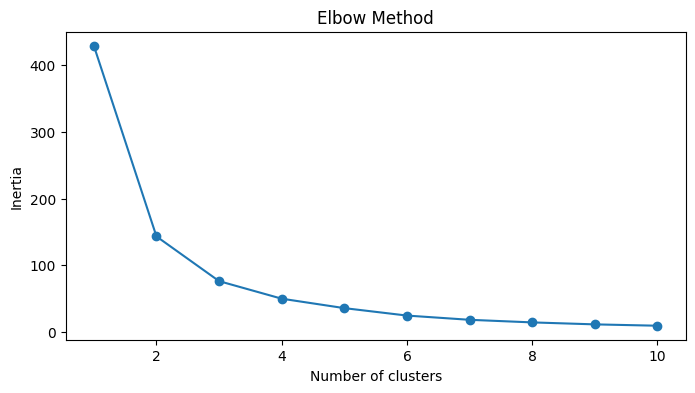

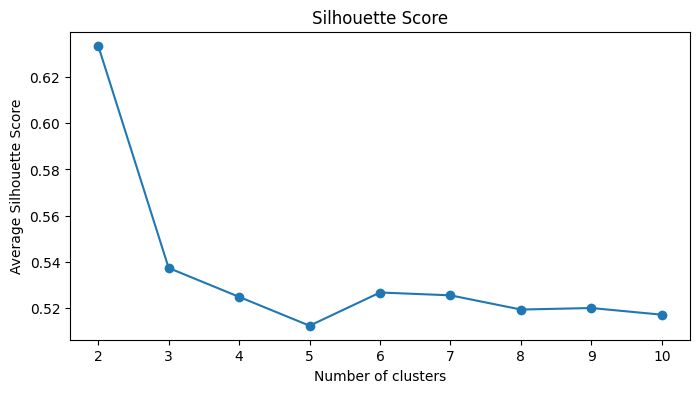

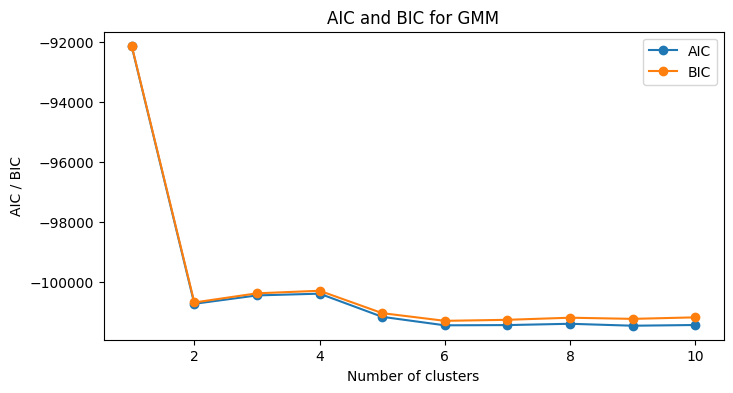

In [66]:
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
tokens = list(token_sim.keys())
similarities = list(token_sim.values())

# Clustering des Similarités
similarities_array = np.array(similarities).reshape(-1, 1)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(similarities_array)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


silhouette_avg = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(similarities_array)
    silhouette_avg.append(silhouette_score(similarities_array, kmeans.labels_))

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_avg, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

# AIC et BIC pour GMM
aic = []
bic = []
for k in range(1, 11):
    gmm = GaussianMixture(n_components=k, random_state=0).fit(similarities_array)
    aic.append(gmm.aic(similarities_array))
    bic.append(gmm.bic(similarities_array))

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), aic, marker='o', label='AIC')
plt.plot(range(1, 11), bic, marker='o', label='BIC')
plt.title('AIC and BIC for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('AIC / BIC')
plt.legend()
plt.show()
# Affichage des résultats du clustering
# plt.figure(figsize=(10, 6))
# for i, token in enumerate(tokens):
#     plt.scatter(i, similarities[i], color=f'C{clusters[i]}', label=f'Cluster {clusters[i]}' if i == 0 else "")

# plt.title('Clustering des Tokens par Similarité Cosinus')
# plt.xlabel('Index du Token')
# plt.ylabel('Similarité Cosinus')
# plt.legend()
# plt.show()

# # Afficher les tokens regroupés par clusters
# clustered_tokens = {i: [] for i in range(3)}
# for token, cluster in zip(tokens, clusters):
#     clustered_tokens[cluster].append(token)

# for cluster, cluster_tokens in clustered_tokens.items():
#     print(f"Cluster {cluster}: {cluster_tokens}")

Similarité cosinus moyenne pour les noms propres: 0.39697741997706426
Similarité cosinus moyenne pour les autres tokens: 0.4231298052178802
0.3737373948097229
  Mode: 0.6434905529022217
  Standard Deviation: 0.11104339629317435
Min 0.1482565850019455
Statistique t: -9.355262145621534, Valeur p: 2.5491861132651223e-20
La différence de similarités cosinus est statistiquement significative.


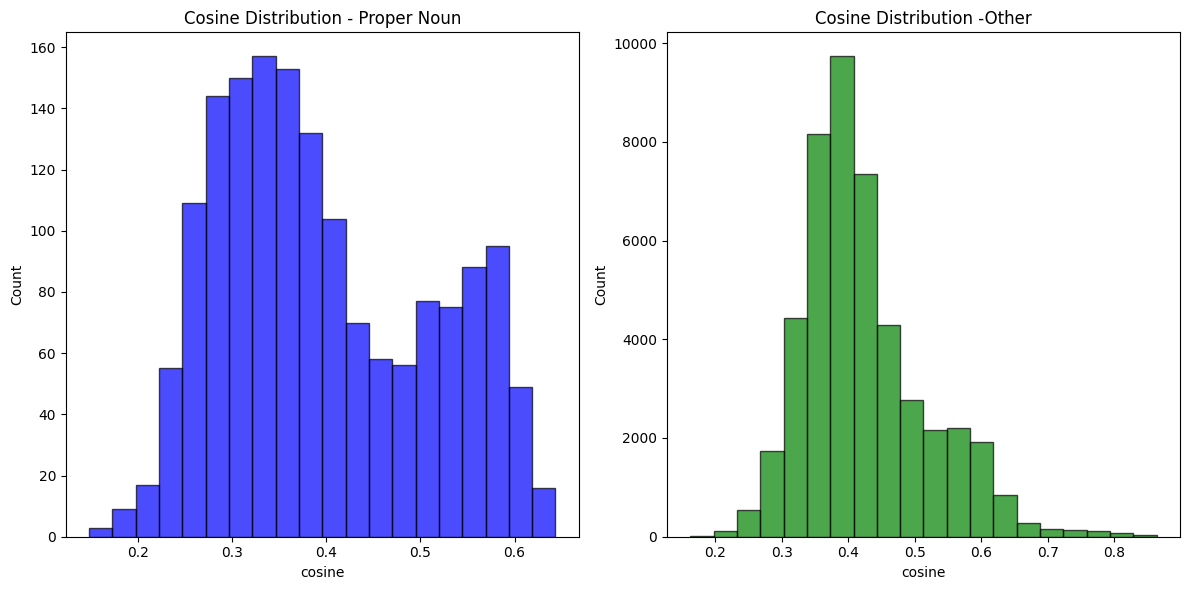

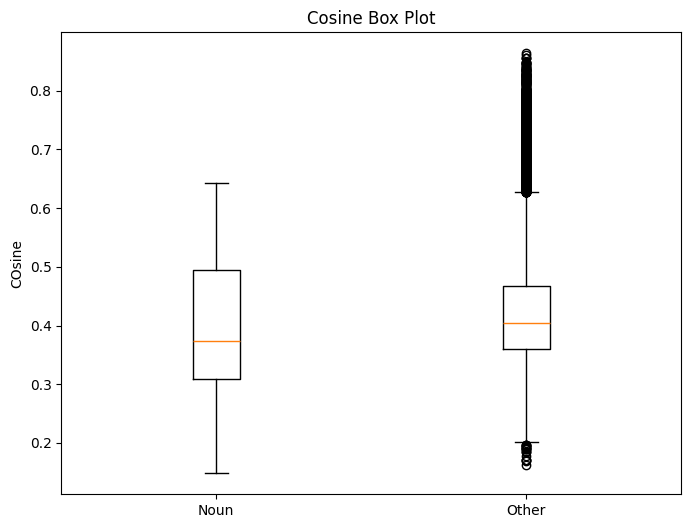

In [61]:
proper_noun_similarities = [similarity for token_id, similarity in zip(token_sim.keys(),token_sim.values()) if token_id in names_entity_pr]
other_token_similarities = [similarity for token_id, similarity in zip(token_sim.keys(),token_sim.values()) if token_id not in names_entity_pr]
# Calculer les similarités cosinus moyennes
avg_proper_noun_similarity = np.mean(proper_noun_similarities)
avg_other_token_similarity = np.mean(other_token_similarities)

print(f"Similarité cosinus moyenne pour les noms propres: {avg_proper_noun_similarity}")
print(f"Similarité cosinus moyenne pour les autres tokens: {avg_other_token_similarity}")
print(np.median(proper_noun_similarities))
print(f"  Mode: {max(set(proper_noun_similarities), key=proper_noun_similarities.count)}")
print(f"  Standard Deviation: {np.std(proper_noun_similarities)}")
print(f"Min",np.min(proper_noun_similarities))
# Effectuer un test t
t_stat, p_value = ttest_ind(proper_noun_similarities, other_token_similarities, equal_var=False)
print(f"Statistique t: {t_stat}, Valeur p: {p_value}")

# Interprétation
if p_value < 0.05:
    print("La différence de similarités cosinus est statistiquement significative.")
else:
    print("La différence de similarités cosinus n'est pas statistiquement significative.")
    
    
    
# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(proper_noun_similarities, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Cosine Distribution - Proper Noun')
plt.xlabel('cosine')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(other_token_similarities, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Cosine Distribution -Other')
plt.xlabel('cosine')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Plot box plots
plt.figure(figsize=(8, 6))
plt.boxplot([proper_noun_similarities,other_token_similarities], labels=['Noun', 'Other'])
plt.title('Cosine Box Plot')
plt.ylabel('COsine')
plt.show()

In [58]:
high_token_noun=[token_id for token_id, similarity in token_sim.items() if token_id in names_entity_pr and similarity > 0.55]
print(high_token_noun)

['Schwart', 'Blan', 'Gbg', 'Robertson', 'Samantha', 'Nattens', 'Helin', 'Watts', 'Husse', 'Hudd', 'Dres', 'Maxwell', 'Quinn', 'Weather', 'Shirley', 'Alyson', 'Look', 'Juliette', 'Bailey', 'Geoff', 'Stiller', 'Liz', 'Kahn', 'Diam', 'Ferdin', 'Leaf', 'Girls', 'Stoltz', 'Happ', 'Reine', 'Ethan', 'Labrador', 'Hedem', 'Centra', 'Newman', 'Vane', 'Benj', 'Miranda', 'Pointe', 'Brid', 'Roseng', 'Barber', 'Jacqueline', 'Schumacher', 'Easy', 'Kane', 'Nich', 'Polo', 'Carneg', 'Hellqvist', 'Gérard', 'Boarea', 'Miin', 'Lambert', 'Torres', 'Duff', 'Sila', 'Higg', 'Kyle', 'Charl', 'Mellberg', 'Weise', 'Berry', 'Singer', 'Halfvarsson', 'Wider', 'Pyong', 'Ruby', 'Armst', 'Wesley', 'Basil', 'Emanuelsson', 'Igh', 'Tintin', 'Gord', 'Head', 'Griffith', 'Widerberg', 'Molly', 'Sidney', 'Cag', 'Isab', 'Dead', 'Skarab', 'Mits', 'Raymond', 'Dawn', 'Tandberg', 'Pine', 'Putte', 'Horace', 'Jubile', 'Gerry', 'Range', 'Greene', 'Malmsjö', 'Quin', 'Jaros', 'Blanca', 'Jolie', 'Wilder', 'Möbl', 'Gess', 'Diaz', 'Nyzeel'

In [ ]:
proper_noun_similarities = [(token, similarity) for token, similarity in cclassified_words if token in named_entities]

# Trier les similarités cosinus par ordre croissant
sorted_proper_noun_similarities = sorted(proper_noun_similarities, key=lambda x: x[1])
sorted_proper_noun_similarities [-100:]

In [ ]:
#Correaltion between frequency and cosine similarity in word embedding 
from scipy.stats import spearmanr, pearsonr

frequency_dict = {word: count for word, count in most_frequent_words}
token_sim = [token for token,_ in cclassified_words]
aligned_frequency_scores = [frequency_dict[word] for word in token_sim]
cosine_similarity=[sim for word,sim in cclassified_words]


pearson_corr, _ = pearsonr(cosine_similarity, aligned_frequency_scores)
print(f'Corrélation de Pearson : {pearson_corr}')

# Calculer la corrélation de Spearman
spearman_corr, _ = spearmanr(cosine_similarity, aligned_frequency_scores)
print(f'Corrélation de Spearman : {spearman_corr}')

# Combine frequencies and cosine similarities
frequency_similarity_pairs = [(freq, sim) for sim, freq in zip(cosine_similarity, aligned_frequency_scores )]
freqs, sims = zip(*frequency_similarity_pairs)

# Calculate Pearson correlation
pearson_corr, p_value = pearsonr(freqs, sims)
print(f"Pearson correlation: {pearson_corr}, P-value: {p_value}")
spearman_corr, p_value = spearmanr(freqs, sims)
print(f"Spearman correlation: {spearman_corr}, P-value: {p_value}")

plt.scatter(sims,freqs, alpha=0.5)
plt.title('Token Frequency vs. Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()
import pandas as pd

# Create a DataFrame for easier manipulation
df = pd.DataFrame(frequency_similarity_pairs, columns=['Frequency', 'Cosine Similarity'])

# Bin the frequencies
df['Frequency Bin'] = pd.qcut(df['Cosine Similarity'], q=10, duplicates='drop')

# Plot box plot
plt.figure(figsize=(12, 6))
df.boxplot(column='Frequency', by='Frequency Bin', grid=False, showfliers=False)
plt.title(' Frequency Bin by Cosine Similarity')
plt.suptitle('')
plt.xlabel('Cosine Bin')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import numpy as np

frequency_last_100 = [frequency_dict[word] for word in token_sim[-100:]]
print("mean frequency last 100",np.mean(frequency_last_100))

frequency_first_100 = [frequency_dict[word] for word in token_sim[:100]]
print("mean frequency first 100",np.mean(frequency_first_100))




# Perform t-test
t_stat, p_value = ttest_ind(frequency_last_100, frequency_first_100, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The difference in frequencies is statistically significant.")
else:
    print("The difference in frequencies is not statistically significant.")
    
    

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(frequency_last_100, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Frequency Distribution - Last 100 Tokens')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(frequency_first_100, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Frequency Distribution - First 100 Tokens')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Plot box plots
plt.figure(figsize=(8, 6))
plt.boxplot([frequency_last_100, frequency_first_100], labels=['Last 100 Tokens', 'First 100 Tokens'])
plt.title('Frequency Box Plot')
plt.ylabel('Frequency')
plt.show()


def print_statistics(data, label):
    print(f"Statistics for {label}:")
    print(f"  Mean: {np.mean(data)}")
    print(f"  Median: {np.median(data)}")
    print(f"  Mode: {max(set(data), key=data.count)}")
    print(f"  Standard Deviation: {np.std(data)}")
    print(f"  Min: {np.min(data)}")
    print(f"  Max: {np.max(data)}")
    print()

print_statistics(frequency_last_100, "Last 100 Tokens")
print_statistics(frequency_first_100, "First 100 Tokens")

In [ ]:
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
euclidean_measures =[]
cosine_measures = []
tokens=[]
for token in filtered_datasets.keys() :
    valid_sentence_filtered = filtered_datasets[token]
    dataloader  =preprocessing.create_dataloader(valid_sentence_filtered,1,default_data_collator)
    baseline_embeddings = comprehension_model.get_embeddings(model_kb, dataloader, tokenizer)
    finetuned_embeddings = comprehension_model.get_embeddings(model_hugging_face, dataloader, tokenizer)
    euclidean_distances = [euclidean(baseline, finetuned) for baseline, finetuned in zip(baseline_embeddings[-1], finetuned_embeddings[-1])]
    euclidean_measures.append(np.mean(euclidean_distances))
    cosine_measure = cosine_similarity(baseline_embeddings[-1], finetuned_embeddings[-1])
    avg_cosine = np.mean(cosine_measure)
    cosine_measures.append(avg_cosine)
    tokens.append(token)
    with open("word_embedding_distance_layer12.csv", "a") as file:
        writer = csv.writer(file)
        writer.writerow([i, token,np.mean(euclidean_distances),avg_cosine ])
    print(tokenizer.decode(token))
    
high_separated_indices12 = sorted(range(len(euclidean_measures)), key=lambda i: euclidean_measures[i], reverse=True)[:50]
least_separated_indices12 = sorted(range(len(euclidean_measures)), key=lambda i: euclidean_measures[i])[:50]
high_separated_values12 = [euclidean_measures[i] for i in high_separated_indices12]
least_separated_values12 = [euclidean_measures[i] for i in least_separated_indices12]
print(high_separated_values12)
print(least_separated_values12)
high_separated_tokens12 = [tokens[i] for i in high_separated_indices12]
least_separated_tokens12 = [tokens[i] for i in least_separated_indices12]
high_separated_words12 = [tokenizer.decode([idx]) for idx in high_separated_tokens12]
least_separated_words12 = [tokenizer.decode([idx]) for idx in least_separated_tokens12]
print(high_separated_words12)
print(least_separated_words12)

In [ ]:
# Compute similarity metrics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

cos_similarities = cosine_similarity(baseline_embeddings[0], finetuned_embeddings[0])
euclidean_distances = [euclidean(baseline, finetuned) for baseline, finetuned in zip(baseline_embeddings[0], finetuned_embeddings[0])]

print("Average Cosine Similarity:", np.mean(cos_similarities))
print("Average Euclidean Distance:", np.mean(euclidean_distances))

In [ ]:
model_hugging_face.bert.encoder.layer[0].output.dense.weight.shape

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the kernelized correlation coefficient function
def kernelized_corr_coef(x, y, K1, K2, K12, emb_mean1, emb_mean2, n):
    with torch.no_grad():
        mu1, mu2 = x @ emb_mean1, y @ emb_mean2
        mu12 = torch.outer(mu1, mu2)
        x_norm, y_norm = map(lambda x, K, mu: (1/n * (x @ K) * x).sum(dim=-1) - mu**2, [x, y], [K1, K2], [mu1, mu2])
        return (1 / n * x @ K12 @ y.T - mu12) / torch.sqrt(torch.outer(x_norm, y_norm))

# Collect parameters from models
num_layers = 12

multi_WQ_kb = torch.cat([model_kb.state_dict()[f"bert.encoder.layer.{j}.attention.self.query.weight"].T for j in range(num_layers)])
multi_WV_kb = torch.cat([model_kb.state_dict()[f"bert.encoder.layer.{j}.attention.self.value.weight"].T for j in range(num_layers)])    
multi_WK_kb = torch.cat([model_kb.state_dict()[f"bert.encoder.layer.{j}.attention.self.key.weight"].T for j in range(num_layers)])
multi_K_kb = torch.cat([model_kb.state_dict()[f"bert.encoder.layer.{j}.intermediate.dense.weight"] for j in range(num_layers)])
multi_V_kb = torch.cat([model_kb.state_dict()[f"bert.encoder.layer.{j}.output.dense.weight"].T for j in range(num_layers)])
multi_WO_kb = torch.cat([model_kb.state_dict()[f"bert.encoder.layer.{j}.attention.output.dense.weight"] for j in range(num_layers)])
multi_E_kb = model_kb.state_dict()['bert.embeddings.word_embeddings.weight'].T

multi_WQ_ft = torch.cat([model_hugging_face.state_dict()[f"bert.encoder.layer.{j}.attention.self.query.weight"].T for j in range(num_layers)])
multi_WV_ft = torch.cat([model_hugging_face.state_dict()[f"bert.encoder.layer.{j}.attention.self.value.weight"].T for j in range(num_layers)])    
multi_WK_ft = torch.cat([model_hugging_face.state_dict()[f"bert.encoder.layer.{j}.attention.self.key.weight"].T for j in range(num_layers)])
multi_K_ft = torch.cat([model_hugging_face.state_dict()[f"bert.encoder.layer.{j}.intermediate.dense.weight"] for j in range(num_layers)])
multi_V_ft = torch.cat([model_hugging_face.state_dict()[f"bert.encoder.layer.{j}.output.dense.weight"].T for j in range(num_layers)])
multi_WO_ft = torch.cat([model_hugging_face.state_dict()[f"bert.encoder.layer.{j}.attention.output.dense.weight"] for j in range(num_layers)])
multi_E_ft = model_hugging_face.state_dict()['bert.embeddings.word_embeddings.weight'].T

# Ensure correct kernel matrices calculation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    kernel11 = (multi_E_kb @ multi_E_kb.T).to(device)
    kernel22 = (multi_E_ft @ multi_E_ft.T).to(device)
    kernel12 = (multi_E_kb @ multi_E_ft.T).to(device)
    emb_mean1 = torch.mean(multi_E_kb, dim=1).to(device)
    emb_mean2 = torch.mean(multi_E_ft, dim=1).to(device)

# Plotting
plt.figure(figsize=(7.5, 4.25))
for i, (title, param1, param2) in enumerate(tqdm([("$K$", multi_K_kb,multi_K_ft), ("$V$", multi_K_kb, multi_K_ft), ("$W_K$", multi_WK_kb , multi_WK_ft), 
                                                    ("$W_Q$", multi_WQ_kb,multi_WQ_ft), ("$W_V$", multi_WV_kb, multi_WV_ft), ("$W_O$", multi_WO_kb, multi_WO_ft)])):
    with torch.no_grad():
        S = kernelized_corr_coef(param1.to(device), param2.to(device), 
                            kernel11, kernel22, kernel12, 
                            emb_mean1, emb_mean2, n=len(tokenizer))
        layer_size = param1.shape[0] // num_layers
        S_agg = S.view(num_layers, layer_size, num_layers, layer_size).abs().mean([-1, -3]).cpu().numpy()
        
    # Plotting each subplot
    plt.subplot(2, 3, i+1)
    plt.title(title)
    sns.heatmap(S_agg)
    plt.xticks([])
    plt.yticks([])
    
    # Clean up memory
    del S, S_agg
    torch.cuda.empty_cache()

plt.savefig("Correlation_between_layers_embedding_projection.pdf")

# Final memory clean up
del kernel11, kernel22, kernel12
del multi_WQ_kb, multi_WV_kb, multi_WK_kb, multi_K_kb, multi_V_kb, multi_WO_kb, multi_E_kb
del multi_WQ_ft, multi_WV_ft, multi_WK_ft, multi_K_ft, multi_V_ft, multi_WO_ft, multi_E_ft
torch.cuda.empty_cache()



In [ ]:
# Token present in the training dataset

token_frequencies = Counter()


for example in lm_datasets["train"]:
    token_frequencies.update(example['input_ids'])

In [ ]:
#Most frequent token

n = int(len(token_frequencies.keys())*0.8) 
most_common_tokens = token_frequencies.most_common(n)
most_common_ids, most_common_freqs = zip(*most_common_tokens)
most_common_ids_tensor = torch.tensor(most_common_ids)

print("Les IDs des tokens les plus fréquents et leurs fréquences :")
for token_id, freq in zip(most_common_ids, most_common_freqs):
    print(f"Token ID: {token_id}, Fréquence: {freq}")

In [ ]:
comprehension_model.change_embedding_word(model_kb,model_hugging_face,valid_dataset,tokenizer,100)

In [ ]:
import torch

def unique_token_ids(dataset):
    unique_token_ids = set()
    for example in dataset:
        unique_token_ids.update(example['input_ids'])
    return torch.tensor(sorted(unique_token_ids))

def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()

unique_token_id = unique_token_ids(lm_datasets["train"])
print(unique_token_id)
ref_weight = model_kb.bert.embeddings.word_embeddings.weight.detach()[unique_token_id]
bias_weight = model_hugging_face.bert.embeddings.word_embeddings.weight.detach()[unique_token_id]

similarities = [cosine_similarity(ref_weight[i], bias_weight[i]) for i in range(len(unique_token_id))]
    
token_similarity = sorted(zip(unique_token_id, similarities), key=lambda x: x[1], reverse=True)
    
classified_words = [(tokenizer.convert_ids_to_tokens(token_id.item()), similarity) for token_id, similarity in token_similarity]
    
for wrodclassified_words

In [ ]:
with open("cosine_similarity_words_emebdding_cpt", 'w') as file:
        for word, similarity in cclassified_words:
            file.write(f"{word}: {similarity}\n")

In [ ]:
first_100_tokens = token_similarity[:100]
first_classifier_100 = [(tokenizer.convert_ids_to_tokens(token_id.item())) for token_id, similarity in first_100_tokens]
last_100_tokens =token_similarity[-100:]
last_classifier_100 = [(tokenizer.convert_ids_to_tokens(token_id.item())) for token_id, similarity in last_100_tokens]

print(last_classifier_100)
print(first_classifier_100)

In [ ]:
# Graph represent the most changed word embedding thorugh epochs

checkpoint_directory = 'finetuning/finetuning_hugging_whitespace-finetuned-imdb'
checkpoint_files = os.listdir(checkpoint_directory)

checkpoint_files.sort(key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1)))
epoch_data = {}
word_color = {}
total_frequencies = {}
initial_embeddings = model_kb.bert.embeddings.word_embeddings.weight.detach()[most_common_ids_tensor]
colors = plt.cm.viridis(np.linspace(0, 1, 5))
# Training loop
epoch=4
for checkpoint in checkpoint_files:
    epoch +=1
    model = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace-finetuned-imdb/" + checkpoint)
    model=model.to(device)
    #initial_embeddings = embeddings
    embeddings = model.bert.embeddings.word_embeddings.weight.detach()[most_common_ids_tensor]

    embedding_changes = torch.norm(embeddings - initial_embeddings, dim=1)
    
    # Get the top 5 changes
    _, top_indices = torch.topk(embedding_changes, 1)
    top_words = [tokenizer.convert_ids_to_tokens(idx.item()) for idx in top_indices]
    top_changes = embedding_changes[top_indices].tolist()
    for word in top_words:
            if word not in word_color:
                word_color[word] = colors[len(word_color) % len(colors)]
            if word not in total_frequencies :
                total_frequencies[word] =1
            if word  in total_frequencies :
                total_frequencies[word] +=1
        
    # Store data
    epoch_data[epoch] = list(zip(top_words, top_changes))

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
already_labeled = set()
for epoch in epoch_data:
    words, changes = zip(*epoch_data[epoch])
    if words[0] not in already_labeled:
        ax.plot([epoch] * 1, changes, marker='o', linestyle='', markersize=10,color=word_color[words[0]],label=words[0])
        already_labeled.add(words[0])
    else : 
        ax.plot([epoch] * 1, changes, marker='o', linestyle='', markersize=10,color=word_color[words[0]])

ax.set_xlabel('Epoch')
ax.set_ylabel('Change in Norm of Embeddings')
ax.set_title('Most changed word embedding by Epoch')
ax.legend()
plt.show()

In [ ]:
import torch
from transformers import BertTokenizer, BertForMaskedLM
#Saliency scores



model_hugging_face.eval()

# Prepare the text and encode it
text = "skrift om ersättning för resekostnad till och från [MASK] samt ar"
encoded_input = tokenizer(text, return_tensors="pt")
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)
embeddings = model_hugging_face.bert.embeddings(input_ids)
embeddings.retain_grad()
output = model_hugging_face(inputs_embeds=embeddings, attention_mask=attention_mask)
logits = output.logits

mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1].item()

# Extract the logit corresponding to the masked token
masked_token_logit = logits[0, mask_token_index, :]

# Choose the target logit (e.g., the highest probability logit)
target_logit = masked_token_logit.max()

# Backward pass to compute the gradients
model_hugging_face.zero_grad()
target_logit.backward()
# Get the input embeddings
grads = embeddings.grad
print(grads)
# Compute the saliency map as the L2 norm of the gradients
saliency = torch.norm(grads, dim=-1).squeeze()

# Detach and move the saliency map to the CPU
saliency = saliency.detach().cpu().numpy()

# Tokenize the input text to match the saliency scores with the tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().numpy())

# Display the tokens and their saliency scores
for token, score in zip(tokens, saliency):
    print(f"Token: {token}, Saliency: {score}")


In [ ]:

import torch.nn as nn
import torch.nn.functional as F
inputs = valid_filtered_dataset[0]
index = inputs["labels"].index(token_id)
print(index)
criterion =nn.CrossEntropyLoss(reduction='none')
input_ids = torch.tensor(inputs['input_ids'][index-9:index+3], dtype=torch.long).unsqueeze(0).to(device)
attention_mask = torch.tensor(inputs["attention_mask"][index-9:index+3], dtype=torch.long).unsqueeze(0).to(device)
labels = torch.tensor(inputs["labels"][index-9:index+3], dtype=torch.long).unsqueeze(0).to(device)
print(tokenizer.decode(inputs['input_ids'][index-9:index+3]))
print(labels)
with torch.no_grad():
    outputs = model_hugging_face(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels,
        output_attentions=True
    )
softmax_probs = F.softmax(outputs.logits.squeeze()[-3], dim=-1)
sorted_probs, sorted_indices = torch.sort(softmax_probs, descending=True)
sorted_tokens = [tokenizer.decode([idx]) for idx in sorted_indices[:10]]
# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.bar(sorted_tokens, sorted_probs[:10].cpu().numpy())
plt.xlabel('Token')
plt.ylabel('Probability')
plt.title('Top 10 Predicted Tokens and their Probabilities')
plt.show()

{'input_ids': tensor([[    2,  7172,     4,  4315, 33835,  8963,   126, 11261,    76,    97,
         12246,     3]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
{'input_ids': tensor([[    2,  7172,     4,  4315, 33835,  8963,   126, 11261,    76,    97,
         12246,     3]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
2


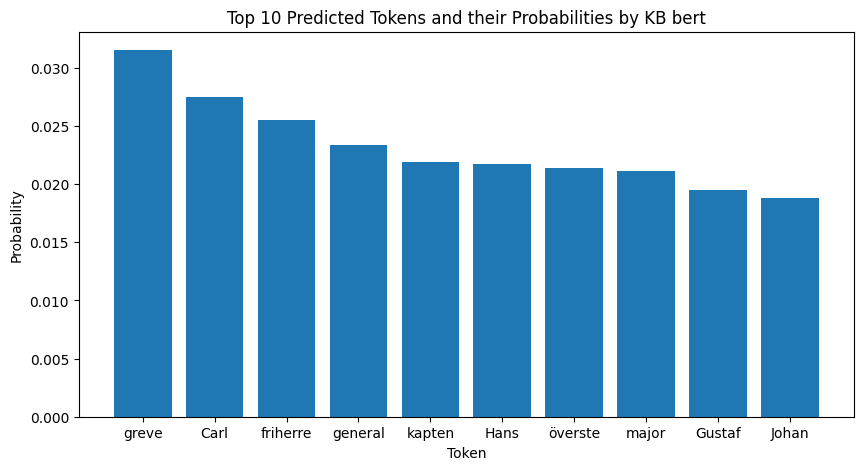

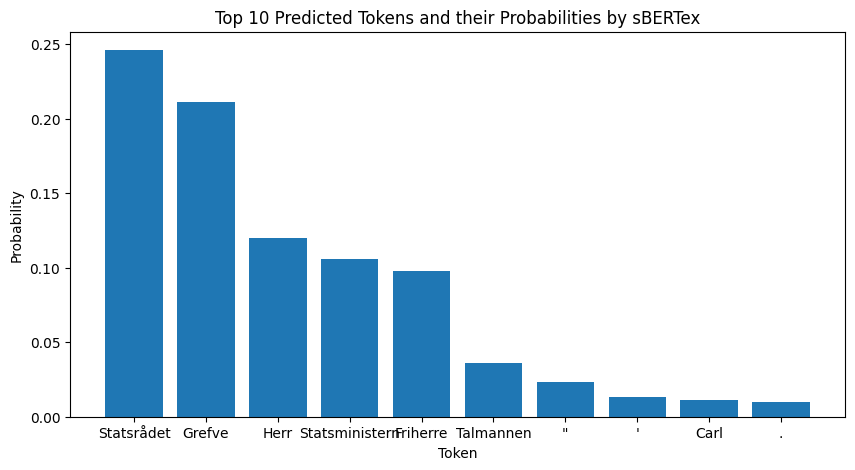

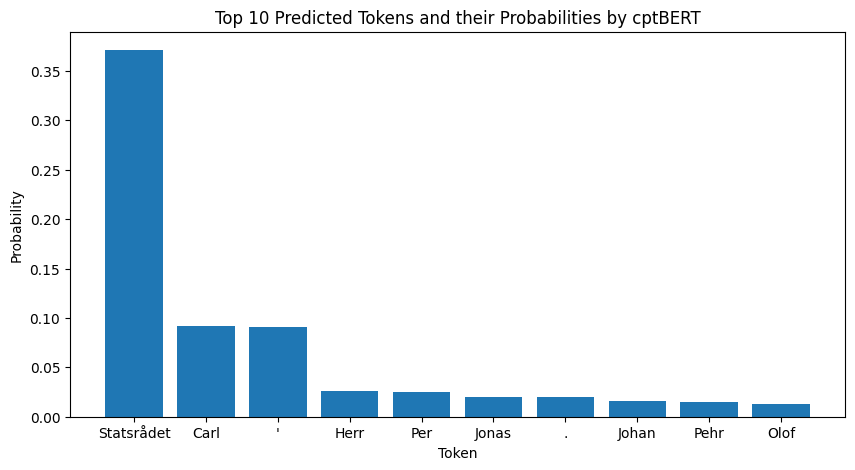

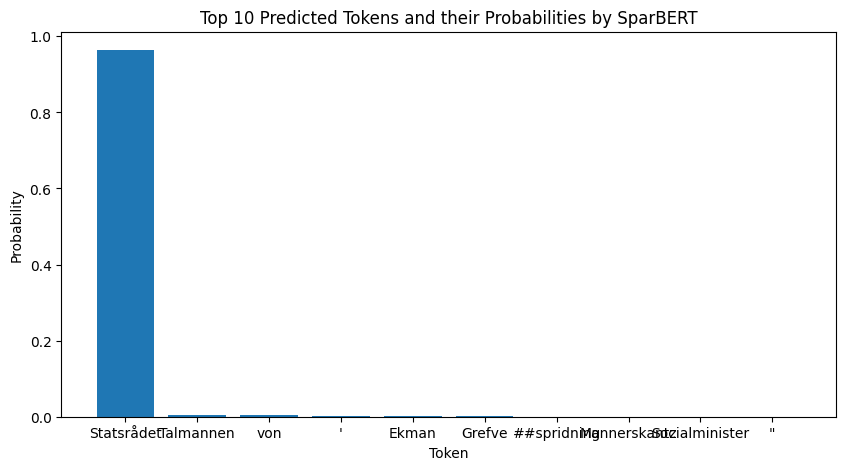

In [19]:

import torch.nn as nn
import torch.nn.functional as F
sentence = "Herr [MASK] von Ehrenheim : Anledningen till den framställning"
input_kb=tokenizer(sentence,return_tensors='pt').to(device)
input_eb=exbert_tokenizer(sentence,return_tensors='pt').to(device)
input_mb=swerick_tokenizer(sentence,return_tensors='pt').to(device)
model_kb.to(device)
model_exbert.to(device)
mosaicBert.to(device)
print(input_kb)
print(input_eb)
index  =2
print(index)
criterion =nn.CrossEntropyLoss(reduction='none')

with torch.no_grad():
    outputs1 = model_kb(**input_kb,
        output_attentions=True
    )
    outputs2=model_exbert(**input_eb)
    outputs3=model_hugging_face(**input_kb)
    outputs4=mosaicBert(**input_mb)
    
softmax_probs_kb = F.softmax(outputs1.logits.squeeze()[index], dim=-1)
sorted_probs_kb, sorted_indices_kb = torch.sort(softmax_probs_kb, descending=True)
sorted_tokens_kb = [tokenizer.decode([idx]) for idx in sorted_indices_kb[:10]]
# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.bar(sorted_tokens_kb, sorted_probs_kb[:10].cpu().numpy())
plt.xlabel('Token')
plt.ylabel('Probability')
plt.title('Top 10 Predicted Tokens and their Probabilities by KB bert')
plt.show()

softmax_probs_eb = F.softmax(outputs2.logits.squeeze()[index], dim=-1)
sorted_probs_eb, sorted_indices_eb = torch.sort(softmax_probs_eb, descending=True)
sorted_tokens_eb = [exbert_tokenizer.decode([idx]) for idx in sorted_indices_eb[:10]]
# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.bar(sorted_tokens_eb, sorted_probs_eb[:10].cpu().numpy())
plt.xlabel('Token')
plt.ylabel('Probability')
plt.title('Top 10 Predicted Tokens and their Probabilities by sBERTex')
plt.show()

softmax_probs_cpt = F.softmax(outputs3.logits.squeeze()[index], dim=-1)
sorted_probs_cpt, sorted_indices_cpt = torch.sort(softmax_probs_cpt, descending=True)
sorted_tokens_cpt = [tokenizer.decode([idx]) for idx in sorted_indices_cpt[:10]]
# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.bar(sorted_tokens_cpt, sorted_probs_cpt[:10].cpu().numpy())
plt.xlabel('Token')
plt.ylabel('Probability')
plt.title('Top 10 Predicted Tokens and their Probabilities by cptBERT')
plt.show()

softmax_probs_sp = F.softmax(outputs4.logits.squeeze()[index], dim=-1)
sorted_probs_sp, sorted_indices_sp = torch.sort(softmax_probs_sp, descending=True)
sorted_tokens_sp = [swerick_tokenizer.decode([idx]) for idx in sorted_indices_sp[:10]]
# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.bar(sorted_tokens_sp, sorted_probs_sp[:10].cpu().numpy())
plt.xlabel('Token')
plt.ylabel('Probability')
plt.title('Top 10 Predicted Tokens and their Probabilities by SparBERT')
plt.show()

In [ ]:
def special_token(token,example):
    return token in example['labels']
word = "Statsrådet"
token_id = tokenizer.convert_tokens_to_ids(word)
valid_filtered_dataset = valid_dataset.select(range(100000)).filter(lambda example : special_token(token_id,example))
valid_filtered_dataloader=preprocessing.create_dataloader(valid_filtered_dataset,64,default_data_collator)

In [ ]:
##LOGIT LENS

import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import torch.nn.functional as F
# Charger le modèle et le tokenizer

def get_probability_distribution(sentence,model):
# Mettre le modèle en mode évaluation
    model.eval()
    print(tokenizer.decode(sentence["input_ids"]))

    input_ids = torch.tensor(sentence ['input_ids'],dtype=torch.long).unsqueeze(0).to(device)
    labels = torch.tensor(sentence ['labels'],dtype=torch.long).unsqueeze(0).to(device)
    attention_mask =torch.tensor(sentence ['attention_mask'],dtype=torch.long).unsqueeze(0).to(device)
    token_ids = sentence["labels"].index(token_id)
    print(token_ids)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=labels, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states 
    


    embedding_matrix = model.bert.embeddings.word_embeddings.weight  

    for layer_idx, hidden_state in enumerate(hidden_states):
        logits = hidden_state @ embedding_matrix.T 

        # Obtenir les probabilités avec softmax
        probs = torch.nn.functional.softmax(logits.squeeze()[token_ids], dim=-1)  # Shape: (batch_size, sequence_length, vocab_size)

        # Pour chaque token dans la séquence, obtenir les 5 premiers tokens prédits et leurs probabilités
        print(f"Layer {layer_idx}")

        top_probs, top_indices = torch.topk(probs, 5)
        top_tokens = tokenizer.convert_ids_to_tokens(top_indices.tolist())
        for prob, token in zip(top_probs, top_tokens):
            print(f"  {token}: {prob.item()}")
    print("\n")

    softmax_probs = F.softmax(outputs.logits.squeeze()[token_ids], dim=-1)
    top_probs, top_indices = torch.topk(softmax_probs, 5)
    top_tokens = tokenizer.convert_ids_to_tokens(top_indices.tolist())
    for prob, token in zip(top_probs, top_tokens):
        print(f"  {token}: {prob.item()}")
    
    
get_probability_distribution (valid_filtered_dataset[2],model_kb)

In [ ]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import torch.nn.functional as F
get_probability_distribution(valid_filtered_dataset[2],model_hugging_face)

In [ ]:
#tuned lens
import torch.nn as nn
def train_translators (model,dataloader,num_epochs=5,learning_rate=1e-4):

    class Translator(nn.Module):
        def __init__(self, hidden_size, vocab_size):
            super(Translator, self).__init__()
            self.linear = nn.Linear(hidden_size, vocab_size)

        def forward(self, x):
            return self.linear(x)
    
    
    

    num_layers = model.config.num_hidden_layers
    hidden_size = model.config.hidden_size
    vocab_size = model.config.vocab_size

    translators = nn.ModuleList([Translator(hidden_size, vocab_size) for _ in range(num_layers)])
    translators.to(device)
    # Training parameters
    num_epochs = num_epochs
    learning_rate = learning_rate
    
    for layer_index in range(1,13) :
        
        optimizer = torch.optim.Adam(translators[layer_index-1].parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            for batch in dataloader:
                batch={key: value.to(device) for key,value in batch.items()}
                optimizer.zero_grad()
                with torch.no_grad():
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
                    hidden_states = outputs.hidden_states
                    final_logits = outputs.logits

                loss = 0
                projected_logits = translators[layer_idx](hidden_states[layer_index].to(device))
                distillation_loss = F.mse_loss(projected_logits, final_logits)
                loss += distillation_loss

                loss.backward()
                optimizer.step()
                
                
        print(f"layer {layer_index }")
    return translators
    
    

In [ ]:
translators_kb=train_translators(model_kb,small_valid_dataloader)
translators_ft = train_translators(model_hugging_face,small_valid_dataloader)

In [ ]:
def get_probability_distribution_tuned(sentence,model,translators):
# Mettre le modèle en mode évaluation
    model.eval()
   

    input_ids = torch.tensor(sentence ['input_ids'],dtype=torch.long).unsqueeze(0).to(device)
    labels = torch.tensor(sentence ['labels'],dtype=torch.long).unsqueeze(0).to(device)
    attention_mask =torch.tensor(sentence ['attention_mask'],dtype=torch.long).unsqueeze(0).to(device)
    token_ids = sentence["labels"].index(token_id)
    print(token_ids)
    print(tokenizer.decode(sentence["input_ids"][token_ids-1:token_ids+4]))
    with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=labels, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states 
    
    predictions = {}
    for layer_idx, hidden_state in enumerate(hidden_states[1:]):
        logits = translators[layer_idx](hidden_state) 
        probs = torch.nn.functional.softmax(logits.squeeze()[token_ids], dim=-1)  # Shape: (batch_size, sequence_length, vocab_size)

        # Pour chaque token dans la séquence, obtenir les 5 premiers tokens prédits et leurs probabilités
        top_probs, top_indices = torch.topk(probs, 5)
        top_tokens = tokenizer.convert_ids_to_tokens(top_indices.tolist())
        predictions[f"Layer {layer_idx + 1}"] = [(token, prob.item()) for token, prob in zip(top_tokens, top_probs)]
        

    softmax_probs = F.softmax(outputs.logits.squeeze()[token_ids], dim=-1)
    top_probs, top_indices = torch.topk(softmax_probs, 5)
    top_tokens = tokenizer.convert_ids_to_tokens(top_indices.tolist())
    predictions["output"]=[(token, prob.item()) for token, prob in zip(top_tokens, top_probs)]
    for prob, token in zip(top_probs, top_tokens):
        print(f"  {token}: {prob.item()}")
    return predictions

In [ ]:
 
sentence = valid_filtered_dataset[16]
token_ids= sentence["labels"].index(token_id)  

In [ ]:
get_probability_distribution_tuned(sentence,model_kb,translators_kb)

In [ ]:
get_probability_distribution_tuned(sentence,model_hugging_face,translators_ft)

In [ ]:
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForMaskedLM
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def pivot_graph(predictions, model_name, sentence):
    data = []
    for layer in range(1, 13):
        tokens_probs = predictions[f"Layer {layer}"]
        for rank, (token, prob) in enumerate(tokens_probs):
            data.append({
                "Layer": layer,
                "Rank": rank + 1,
                "Token": token,
                "Probability": prob
            })
    for rank, (token, prob) in enumerate(predictions["output"]):
        data.append({
            "Layer": "output",
            "Rank": rank + 1,
            "Token": token,
            "Probability": prob
        })

    df = pd.DataFrame(data)
    pivot_table = df.pivot(index="Layer", columns="Rank", values="Probability")
    token_pivot = df.pivot(index="Layer", columns="Rank", values="Token")

    plt.figure(figsize=(12, 8))
    plt.text(0.5, 1.15, sentence, horizontalalignment='center', fontsize=12, transform=plt.gca().transAxes)
    ax = sns.heatmap(pivot_table, annot=token_pivot, fmt='', cmap="Blues", cbar_kws={'label': 'Probability'})
    ax.set_title(f"Tuned Lens Predictions for {model_name}")
    ax.set_xlabel("Top Predicted Tokens")
    ax.set_ylabel("Layer")

    ax.set_xticklabels([str(i) for i in range(1, pivot_table.columns.size + 1)], rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


sentence_token = tokenizer.decode(sentence["input_ids"][token_ids-10:token_ids+3])
print(sentence_token)
pivot_graph(prediction_kb,'KB Bert',sentence_token)
pivot_graph(prediction_ft,'Finetuned Model',sentence_token)

In [ ]:
# autre essai
from transformers import BertConfig, BertForMaskedLM

def verify_all_layers_scratch_in_base(model, model_scratch):
    n_in = 0
    for layer in model_scratch.state_dict().keys():
        if layer in model.state_dict().keys():
            n_in += 1
    return n_in == len(model_scratch.state_dict())


def copy_layers_from_pretrained(model, model_scratch, log=False):
    for layer in model_scratch.state_dict().keys():
        model_scratch.state_dict()[layer] = model_scratch.state_dict()[layer].copy_(model.state_dict()[layer])
    
    if log:
        print("Copy done successfully!")
    
    return model_scratch


def generate_prediction_trajectory(model, sentence, masked_index,token_id):
    input_ids = torch.tensor(sentence['input_ids'],dtype=torch.long).unsqueeze(0).to(device)
    labels = torch.tensor(sentence['labels'],dtype=torch.long).unsqueeze(0).to(device)
    attention_mask =torch.tensor(sentence ['attention_mask'],dtype=torch.long).unsqueeze(0).to(device)
    token_ids = sentence["labels"].index(token_id)
    print(token_ids)
    print(tokenizer.decode(sentence["input_ids"][token_ids-1:token_ids+4]))
    with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=labels, attention_mask=attention_mask, output_hidden_states=True)
        logits = outputs.logits
        
    final_predictions = logits.argmax(dim=-1)
    label_pred_final = token_id
    label_confidence_final = logits.max(dim=-1)

    _, indexes_sorted = torch.sort(logits, descending=True)
    final_label_rank = torch.where(indexes_sorted[0, masked_index] == label_pred_final)[0].item()

    prediction_trajectory = []
    rank_trajectory = []
    interm_label_confidence_evolution = []

    total_hidden_layers = model.config.num_hidden_layers

    for num_interm_layers in tqdm(range(1, total_hidden_layers + 1)):
        config = BertConfig.from_pretrained(model.config.name_or_path)
        config.num_hidden_layers = num_interm_layers

        model_scratch = BertForMaskedLM(config)
        model_scratch.to(device)

        if verify_all_layers_scratch_in_base(model, model_scratch):
            model_interm = copy_layers_from_pretrained(model, model_scratch)
            outputs_interm = model_interm(**inputs)
            logits_interm = outputs_interm.logits
            label_pred_interm = logits_interm.argmax(dim=-1)[0, masked_index].item()
            interm_label_confidence = F.softmax(logits_interm, dim=-1)[0, masked_index, label_pred_interm].item()

            interm_final_label_confidence = F.softmax(logits_interm, dim=-1)[0, masked_index, label_pred_final].item()
            
            _, indexes_sorted_interm = torch.sort(logits_interm, descending=True)
            interm_final_label_rank = torch.where(indexes_sorted_interm[0, masked_index] == label_pred_final)[0].item()

            prediction_trajectory.append(tokenizer.convert_ids_to_tokens(label_pred_interm))
            rank_trajectory.append(torch.where(indexes_sorted[0, masked_index] == label_pred_final)[0].item())
            interm_label_confidence_evolution.append(label_confidence_final)

    prediction_trajectory.append(tokenizer.convert_ids_to_tokens(final_predictions[0, masked_index].item()))
    rank_trajectory.append(interm_final_label_rank)
    interm_label_confidence_evolution.append(interm_label_confidence)
    return prediction_trajectory, rank_trajectory, interm_label_confidence_evolution



prediction_kb,rank_kb,proba_kb = generate_prediction_trajectory(model_kb,sentence,token_ids,token_id)
prediction_ft,rank_ft,proba_ft = generate_prediction_trajectory(model_hugging_face,sentence,token_ids,token_id)

In [ ]:
proba_ft

In [ ]:
import numpy as np
def plot_trajectory(prediction_trajectories, probabilities, y_labels, figsize=(25, 10), fontsize=15):
    tableau = np.array(prediction_trajectories)
    gradient = np.array(probabilities)

    normalized_probs = (gradient - np.min(gradient)) / (np.max(gradient) - np.min(gradient))

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(normalized_probs, cmap='viridis', aspect='auto')

    ax.set_xticks(np.arange(tableau.shape[1]))
    ax.set_xticklabels([f'layer {i+1}' for i in range(tableau.shape[1]-1)]+ ['Output'])
    ax.set_xlabel('num_hidden_layers')

    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels,  color='black', fontsize=fontsize)

    for i in range(tableau.shape[0]):
        for j in range(tableau.shape[1]):
            ax.text(j, i, tableau[i, j], ha='center', va='center', color='w' if normalized_probs[i, j] <= 0.5 else 'black', fontsize=fontsize)

    cbar = fig.colorbar(cax, fraction=0.03, pad=0.05)
    cbar.set_label('Probability')

    plt.show()
    
    
plot_trajectory([prediction_kb,prediction_ft],[proba_kb,proba_ft], y_labels = ["KB Bert","Finetuned"], figsize = (40, 15), fontsize=16)